<a href="https://colab.research.google.com/github/weberlu88/2020-Spring-MIS-AI/blob/master/CNN/cifer10_90_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Accuracy 90% Go Go

Using image augmentation to reach 90.3% accuracy on CIFAR_10 with a simple CNN.

The codes I refer: https://github.com/moritzhambach/Image-Augmentation-in-Keras-CIFAR-10-/blob/master/CNN%20with%20Image%20Augmentation%20(CIFAR10).ipynb

- ModelCheckpoint: https://keras.io/callbacks/#modelcheckpoint
- 如何使用Keras fit和fit_generator: https://blog.csdn.net/learning_tortosie/article/details/85243310

In [1]:
import keras as k
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.models import load_model
from keras.regularizers import l2
from keras.callbacks.callbacks import ModelCheckpoint

import tensorflow as tf
import numpy as np                                
import matplotlib.pyplot as plt
import h5py

Using TensorFlow backend.


## Load Data

170500096/170498071 [==============================] - 4s 0us/step


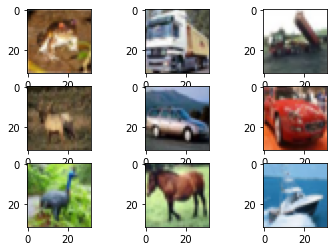

In [2]:
# load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_rows, img_cols , channels= 32,32,3
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i])
plt.show()

## ImageDataGenerator

In [0]:
# set up image augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    #zoom_range=0.3
    )
datagen.fit(x_train)

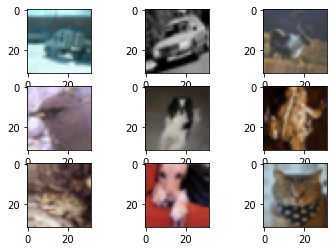

In [4]:
# see example augmentation images
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break

## Reshape into images

In [5]:
#reshape into images
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, 1)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [0]:
#convert integers to float; normalise and center the mean
x_train=x_train.astype("float32")  
x_test=x_test.astype("float32")
mean=np.mean(x_train)
std=np.std(x_train)
x_test=(x_test-mean)/std
x_train=(x_train-mean)/std

## Labels

In [0]:
# labels
num_classes=10
y_train = k.utils.to_categorical(y_train, num_classes)
y_test = k.utils.to_categorical(y_test, num_classes)

## Plotting helper function

In [0]:
# plotting helper function
def plothist(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## Build the Model

In [0]:
# variables
batch_size = 128
num_classes = 10
epochs = 150

#reg=l2(1e-4)   # L2 or "ridge" regularisation
reg=None
num_filters=32
ac='relu'
adm=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
opt=adm
drop_dense=0.5
drop_conv=0

In [0]:
# build and compile the model  (roughly following the VGG paper)

model = Sequential()

model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, input_shape=(img_rows, img_cols, channels), padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
model.add(Dropout(drop_conv))

model.add(Conv2D(2*num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(2*num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
model.add(Dropout(drop_conv))

model.add(Conv2D(4*num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(4*num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
model.add(Dropout(drop_conv))

model.add(Flatten())
model.add(Dense(512, activation=ac,kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(Dropout(drop_dense))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)       

## Train

In [0]:
# checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [13]:
# train with image augmentation
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                              steps_per_epoch = len(x_train) / 128, 
                              epochs=epochs, 
                              validation_data=(x_test, y_test),
                              callbacks=[checkpoint])

                              # callbacks=[checkpoint]

Epoch 1/150
391/390 [==============================] - 38s 97ms/step - loss: 1.6452 - accuracy: 0.4599 - val_loss: 1.2418 - val_accuracy: 0.5584

Epoch 00001: val_accuracy improved from -inf to 0.55840, saving model to weights.best.hdf5
Epoch 2/150
391/390 [==============================] - 30s 77ms/step - loss: 1.0983 - accuracy: 0.6114 - val_loss: 0.8798 - val_accuracy: 0.6943

Epoch 00002: val_accuracy improved from 0.55840 to 0.69430, saving model to weights.best.hdf5
Epoch 3/150
391/390 [==============================] - 30s 77ms/step - loss: 0.9052 - accuracy: 0.6825 - val_loss: 0.8334 - val_accuracy: 0.7192

Epoch 00003: val_accuracy improved from 0.69430 to 0.71920, saving model to weights.best.hdf5
Epoch 4/150
391/390 [==============================] - 30s 76ms/step - loss: 0.7936 - accuracy: 0.7223 - val_loss: 0.7871 - val_accuracy: 0.7336

Epoch 00004: val_accuracy improved from 0.71920 to 0.73360, saving model to weights.best.hdf5
Epoch 5/150
391/390 [======================

## Show Train & Test Results

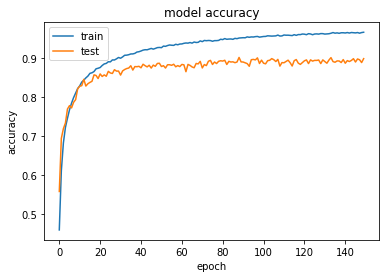

In [14]:
plothist(history)  # 128 batch, 0.001 lr, 512 neurons, no zoom, no convdrop, only 0.1 shift

In [16]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

Test loss:  0.3979271927833557
Test accuracy:  0.8985000252723694


## Save Model
Note: The best epoch result has been saved as `weights.best.hdf5`.

In [0]:
model.save('cifar10_01.h5')                  
#model=load_model('cifar10_01.h5')

Try the best model with 90% test accuracy.

In [18]:
model_best = load_model('weights.best.hdf5')

score = model_best.evaluate(x_test, y_test, verbose=0)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

Test loss:  0.3574392882913351
Test accuracy:  0.9016000032424927
